This notebook is to just plot results

# Parameters to experiment

In [1]:
# display experiment parameters
# Change experiment number here
!cat ./experiments/4/experimentParameters.txt

N° experiment: 4
 Classes: [16]
 train_size: 77996
 validation_size: 9750
 test_size: 9750
 total dataset size: 97496
 Epochs: 1000
 Latent dimension: 100
 Hidden dimension: 100
 Input dimension: 72
 Passband: 5
 Learning rate: 0.001
 Batch training size: 128

In [2]:
# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 4
number_experiment = str(number_experiment)

In [3]:
# classes to analyze
only_these_labels = [16]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

# band
# passband = 5
passband = 5

batch_training_size = 128

# Import libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

%matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

import math

# Load data

In [5]:
# define path to dataset
pathToFile = "/home/leo/Downloads/plasticc_torch-master/"

## Loading dataset with pytorch tool

In [6]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 3 csv files at given path
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_test_set_batch1.csv
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_test_set_batch2.csv


# Spliting data (train/test)

In [7]:
# Spliting the data

# print(torch_dataset_lazy.__len__())

# selecting train splitting
train_size = int(0.8 * torch_dataset_lazy.__len__())
#print(train_size)

# getting test splitting
validation_size = math.floor((torch_dataset_lazy.__len__() - train_size)/2)
#print(validation_size)

# getting test splitting
test_size = torch_dataset_lazy.__len__() - train_size - validation_size
#print(test_size)

# spliting the torch dataset
trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(torch_dataset_lazy, [train_size, validation_size, test_size])

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
print("sum: ", train_size+ validation_size + test_size)

train size: 8552
validation size:  1069
test size: 1070
sum:  10691


## Create a dataloader

In [8]:
# # Create data loader (minibatches)

# # train loader
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size= batch_training_size, shuffle=True, num_workers = 4)

# validation loader
validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size= batch_training_size, shuffle=True, num_workers = 4)

# # test loader
testLoader = torch.utils.data.DataLoader(testDataset)
# trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

## Load the path to save model while training

In [9]:
import os

# create experiment's folder
folder_path = "/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# define paht to save model while training
pathToSaveModel = "/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/model"

## Define autoencoder structure

In [10]:
# Buiding autoencoder

# Assuming this has a normal distrubtion in the latent part

# encoder
class Encoder(torch.nn.Module):
    
    # init method
    def __init__(self, latent_dim, hidden_dim, input_dim):

        super(Encoder, self).__init__()
        
        # 1 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
#         self.conv1 = torch.nn.Conv1d(1,64,3)
        self.conv1 = torch.nn.Conv1d(1,64,3, stride = 2)
        
        
        # 2 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
#         self.conv2 = torch.nn.Conv1d(64, 32, 3)
        self.conv2 = torch.nn.Conv1d(64, 32, 3, stride = 2)
        
        # linear layer
#         self.hidden1 = torch.nn.Linear(2144*2, hidden_dim)
#         self.hidden1 = torch.nn.Linear(1088, hidden_dim)
        self.hidden1 = torch.nn.Linear(1632, hidden_dim)
        
#         self.hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
        
        # mu
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        
        # sigma
        self.logVar = torch.nn.Linear(hidden_dim, latent_dim)
        
        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
#         self.activationConv = torch.nn.Tanh()
    
        # this works well.(comparing with relu)
        self.activationLinear = torch.nn.Tanh()

    # forward method
    def forward(self, x):
        
        # input shape: [batch_size, channels, sequence_length]
        # print("input shape: {0}".format(x.shape))
        
        
        # convolution 1
        # x -> conv -> act -> ouput
        # shape should be: [batch_size, number of ouput channels (64), length of output from convolution]
        
        #conv to time
#         outputTimeConv = self.activationConv(self.conv1Time(x[:, 0, :].unsqueeze(1)))
        outputTimeConv = self.activationConv(self.conv1(x[:, 0, :].unsqueeze(1)))
    
        # conv to magnitude
#         outputMagConv = self.activationConv(self.conv1Mag(x[:, 1, :].unsqueeze(1)))
        outputMagConv = self.activationConv(self.conv1(x[:, 1, :].unsqueeze(1)))
        
        # conv to mag error
        outputMagErrorConv = self.activationConv(self.conv1(x[:, 2, :].unsqueeze(1)))
        
#         print("output conv1 shape: {0}".format(outputMagConv.shape))
#         print("output conv1 shape: {0}".format(outputTimeConv.shape))
        
        # convolution 2
#         # shape should be: [batch_size, number of ouput channels (32), length of output from convolution]
        
        # conv to time
        outputTimeConv = self.activationConv(self.conv2(outputTimeConv))
    
        # conv to flux
        outputMagConv = self.activationConv(self.conv2(outputMagConv))
        
        # conv to mag error
        outputMagErrorConv = self.activationConv(self.conv2(outputMagErrorConv))
        
#         print("output conv2 shape: {0}".format(outputTimeConv.shape))
#         print("output conv2 shape: {0}".format(outputMagConv.shape))
        
        # flatten ouput
        # shape should be: [batch_size, -1]
        outputMagConv = outputMagConv.view(outputMagConv.shape[0], -1)
        
        outputTimeConv = outputTimeConv.view(outputTimeConv.shape[0], -1)
        
        outputMagErrorConv = outputMagErrorConv.view(outputMagErrorConv.shape[0], -1)
        
#         print("output reshape: ", outputMagConv.shape)
#         print("output reshape: ", outputTimeConv.shape)
                
        # concatenate 2 towers
#         output = torch.cat((outputMagConv, outputTimeConv), 1)
        output = torch.cat((outputTimeConv, outputMagConv, outputMagErrorConv), 1)
    
#         print("concatenate output shape: ", output.shape)
        
        # x -> hidden1 -> activation
#         print("before linear layer: {0}".format(output.shape))
        output = self.activationLinear(self.hidden1(output))
        
        
#         second hidden layer
#         output = self.activationLinear(self.hidden2(output))
#         output = self.activationLinear(self.hidden2(output))
    
#         output = self.hidden1(output)
#         print("hidden1 output shape: {0}".format(output.shape))
        
        # get mu
        # sin tangenteh!!!
        mu = self.mu(output)
#         print("mu shape: {0}".format(mu.shape))
        
        # get sigma
        logVar = self.logVar(output)
#         print("sigma shape: {0}".format(logVar.shape))
        
        # returning values
        return mu, logVar

    
# decoder    
class Decoder(torch.nn.Module):
    
    # define layers
    def __init__(self, latent_dim, hidden_dim, output_dim):
        
        super(Decoder, self).__init__()
        
        # linear layer
        self.hidden1 = torch.nn.Linear(latent_dim, 2144*2)
        
        # 1 ConvolutionTrans layer
        self.convTrans1 = torch.nn.ConvTranspose1d(32, 64, 3)
                
        # 2 ConvolutionTrans layer
        self.convTrans2 = torch.nn.ConvTranspose1d(64, 1, 3)

        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
#         self.activationConv = torch.nn.Tanh() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()
#         self.activationLinear = torch.nn.ReLU()
        
    # forward method
    def forward(self, z):
        
#         print("input dimension decoder: {0}".format(z.shape))
        
        # linear (from latent to hidden dimension)
        # z -> linaer layer -> activation -> output
        output = self.activationLinear(self.hidden1(z))
#         print("output hidden1: {0}".format(output.shape))
        
        # split data (into time and flux)
        outputTimeDeconv, outputMagDeconv = torch.split(output, 2144, dim=2)
            
        # reshape each tower (time and magnitude)
        outputTimeDeconv = outputTimeDeconv.view(outputTimeDeconv.shape[0], 32, -1)
        outputMagDeconv = outputMagDeconv.view(outputMagDeconv.shape[0], 32, -1)
        
#         print("output reshape: {0}".format(outputTimeDeconv.shape))
#         print("output reshape: {0}".format(outputMagDeconv.shape))
        
        # 1 convolution
        outputTimeDeconv = self.activationConv(self.convTrans1(outputTimeDeconv))
        outputMagDeconv = self.activationConv(self.convTrans1(outputMagDeconv))
#         print("ouput convTrans1: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans1: {0}".format(outputMagDeconv.shape))
        
        # 2 convolution
        outputTimeDeconv = self.convTrans2(outputTimeDeconv)
        outputMagDeconv = self.convTrans2(outputMagDeconv)
        
#         print("ouput convTrans2: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans2: {0}".format(outputMagDeconv.shape))
        
        # concatenate arrays in order to get the data with 2 channels
        output = torch.cat((outputTimeDeconv, outputMagDeconv), 1)
#         print("concatenate in channels: {0}".format(output.shape))

        # output
        return output

# building the autoencoder     
class AutoEncoder(torch.nn.Module):
    
    # defining the initial structure
    def __init__(self, latent_dim, hidden_dim, input_dim):
        
        super(AutoEncoder, self).__init__()
        
        # defining the encoder
        self.encoder = Encoder(latent_dim, hidden_dim, input_dim)
        
        # defining the decoder
        # note the output dimension in the decoder is the same as input dimension
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    # distribution function
    def sampling(self, mu, logvar, k = 1):
        
        # assumming normal distribution
#         s = torch.exp(0.5*sigma)
#         eps = torch.rand_like(s) # generate a iid standard normal same shape as s
#         return eps.mul(s).add_(mu)
        batch_size, n_latent = logvar.shape
        std = (0.5*logvar).exp()
#         eps = torch.randn(batch_size, k, n_latent, device=std.device, requires_grad=False)
        eps = torch.randn(batch_size, k, n_latent, requires_grad=False)
        if "cuda" in str(mu.device):
            eps = eps.cuda()
        return eps.mul(std.unsqueeze(1)).add(mu.unsqueeze(1))
    
    def get_latent_variables(self, x):
        
        # get mu and logvar
        mu, logVar = self.encoder(x)
        
        # sampling to get the latent variables
        z = self.sampling(mu, logVar)
        
        # return values
        return z
    
    # forward method (how to the nn works)
    def forward(self, x):
        
#         print("input size: {0}".format(x.shape))
        
#         print("## Encoder ##")
        # input (x) -> encoder -> latent variables
        mu, logVar = self.encoder(x)
#         print("output encoder size: {0}".format(mu.shape))
        
#         print("mu ", mu.device)
#         print("var ", logVar.device)
        # getting sample
        # mu, sigma -> distribution -> z
        z = self.sampling(mu, logVar)
#         print("z shape: ", z.shape)
        
#         print("## Dencoder ##")
        # latent variables -> decoder -> reconstruction (x)
        decOutput = self.decoder(z)
#         print("output decoder size: {0}".format(decOutput.shape))
        
        # agregar mu, logvar, decOutput
        return decOutput, mu, logVar

## Defining parameters to Autoencoder

In [11]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

passband = passband

# defining model
model = AutoEncoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim)

In [12]:
# # print("input dimension: {0}".format(len(list(trainLoader))))

# # parameters number
# count = 0

# # # check model dimension
# for name, param in model.state_dict().items():
#     # name: str
#     # param: Tensor
# #     print("{0}: {1} \n".format(name, param.shape))
# #     print(param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1))
# #     print(param.shape)
#     count += param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1)
# # for param in model.parameters():
    
# print("number of parameters: " + str(count))

In [13]:
# it builds a mask for the deltas. It compares the next with the previous one element.
# original mask: [1,1, 0, 0]
# delta mask: [1, 0, 0]
# The same results is got with original_mask[:, 1:]
def generate_delta_mask(mask):
    
    # generate delta mask
#     mask_delta = mask[:, 1:].type(torch.BoolTensor) & mask[:, :-1].type(torch.BoolTensor)
    mask_delta = mask[:, 1:]
    
    return mask_delta

In [14]:
from torch.nn import functional as F

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, mask):
        
    # generate delta mask
    mask = generate_delta_mask(mask).cuda()
    
    # this is considering mask
    # [batch size, 2 (time, mag), lenght of serie]
    BCE = F.mse_loss(recon_x, x, reduction='none')
        
    # applyting mask
    BCE[:, 0, :] = BCE[:, 0, :] * mask
    BCE[:, 1, :] = BCE[:, 1, :] * mask
    
    # reducttion 
    BCE = torch.sum(BCE) / (BCE.shape[0]*BCE.shape[1]*BCE.shape[2])


    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Uncomment this if the previous implementation is not working
#     KLD = 0
    
    return BCE + KLD

In [15]:
# function to generate delta time and flux
# data = [batchSize, channels, [time, flux, err, mask], light curve]
def generateDeltas(data, passBand):
    
    # work with delta time and magnitude
    
#     print("generate deltas input shape: {0}".format(data.shape) )
    # delta time
    tmpDeltaTime = data[:, passBand, 0, 1:] - data[:, passBand, 0, :-1]

#     print("generate deltas time shape: {0}".format(tmpDeltaTime.shape) )

#     # delta magnitude
    tmpDeltaMagnitude = data[:, passBand, 1, 1:] - data[:, passBand, 1, :-1]
#     print("generate deltas flux shape: {0}".format(tmpDeltaMagnitude.shape))
    
    # delta errors
    tmpDeltaMagError = data[:, passBand, 2, 1:] - data[:, passBand, 2, :-1]
    
    # concatenate tensors
#     dataToUse = torch.cat((tmpDeltaTime.unsqueeze(1), tmpDeltaMagnitude.unsqueeze(1)), 1)
    dataToUse = torch.cat((tmpDeltaTime.unsqueeze(1), tmpDeltaMagnitude.unsqueeze(1), tmpDeltaMagError.unsqueeze(1)), 1)
    
#     print("data to use shape: {0}".format(dataToUse.shape))
    
    # normalize data
    # this was commented because it considerate that delta is already a normalization
#     dataToUse = normalizeLightCurve(dataToUse)
    
    # returning data
    return dataToUse

# Analyzing training

<IPython.core.display.Javascript object>


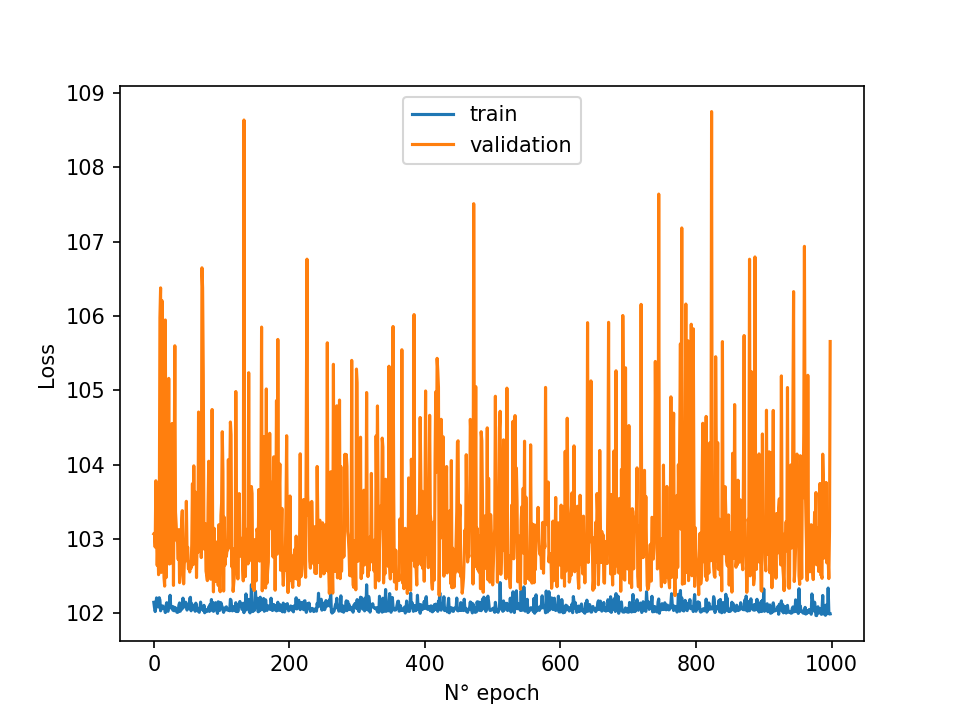

In [16]:
# load losses array
losses = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/training_losses.csv")

# plot losses
fig, ax = plt.subplots()

# axis
ax.set_xlabel("N° epoch")
ax.set_ylabel("Loss")

# plot
ax.plot(losses.iloc[:, 0], label = "train")
ax.plot(losses.iloc[:, 1], label = "validation")
ax.legend()

## Get best model

In [17]:
# Get the best model scores of the training (it's a file)
# change the experiment number
!cat experiments/3/bestScoresModelTraining.txt

Epoch: 508
 Reconstruction test error: 991407.1062011719

In [18]:
# defining model
model = AutoEncoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim)

# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(pathToSaveModel))

model.cuda()

AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
    (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (hidden1): Linear(in_features=1632, out_features=100, bias=True)
    (mu): Linear(in_features=100, out_features=100, bias=True)
    (logVar): Linear(in_features=100, out_features=100, bias=True)
    (activationConv): ReLU()
    (activationLinear): Tanh()
  )
  (decoder): Decoder(
    (hidden1): Linear(in_features=100, out_features=4288, bias=True)
    (convTrans1): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,))
    (convTrans2): ConvTranspose1d(64, 1, kernel_size=(3,), stride=(1,))
    (activationConv): ReLU()
    (activationLinear): Tanh()
  )
)

# Reconstruct light curves

In [19]:
# set dataset to use
loader = testLoader
size = test_size

# define arrays to store data
reconstructedLightCurves = np.zeros(shape = (size, 2, 72 ))
originalLightCurves = np.zeros(shape = (size, 4, 72 ))
mask = np.zeros(shape = (size, 72))
loss_values = np.zeros(shape = (size))

# auxiliar variable
lastIndex = -1


# iterate through dataset (by minibatches)
for i, data_ in enumerate(loader):

    data = data_[0]
    
    # generate data deltas
    data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()
    
    # genreate output model
    outputs, mu, logvar = model.forward(data)
    
    # get loss function value
#     loss_values[lastIndex + 1 : (lastIndex + outputs.shape[0] + 1)] = loss_function(outputs, data, mu, logvar, data_[0][:, passband, 3, :]).detach().cpu()
    loss_values[lastIndex + 1 : (lastIndex + outputs.shape[0] + 1)] = loss_function(outputs, data[:, 0:2, :], mu, logvar, data_[0][:, passband, 3, :]).detach().cpu()
    
    # save orignial light curve
    originalLightCurves[lastIndex + 1 : (lastIndex + outputs.shape[0] + 1), :, : ] = data_[0][:, passband, :, :]
    mask[lastIndex + 1 : (lastIndex + outputs.shape[0] + 1),] = data_[0][:, passband, 3, :]

    # array to store data
    reconstructedLightCurve = np.zeros(shape = data_[0][:, passband, 0:2, :].shape)
    
    
    ######## convert from delta to original format ########
    
    
    
    # adding first element (index 0)
    # adding time with index 0
    reconstructedLightCurve[:, 0, 0] = data_[0][:, passband, 0, 0]
    
    
    # adding flux with index 0
    reconstructedLightCurve[:, 1, 0] = data_[0][:, passband, 1, 0]
    
    
    
    # converting from 1 to end of the light curve
    for i_lightCurve in range(1, data_[0].shape[3]):
        
        
        # add time and flux 
        reconstructedLightCurve[:, :, i_lightCurve] = reconstructedLightCurve[:, :, i_lightCurve-1] + outputs[:, :, i_lightCurve-1].cpu().detach().numpy()
        
    # add lightcurves from batch to array
    reconstructedLightCurves[lastIndex + 1 : (lastIndex + outputs.shape[0] + 1), :, : ] = reconstructedLightCurve

    # update auxiliar variable
    lastIndex = i*outputs.shape[0] + outputs.shape[0] - 1

# Ordering by loss values

In [20]:
# sorted array by loss value
# ascendent order
loss_values_sorted = np.argsort(loss_values)

In [21]:
from scipy import stats

# loss value stats
print(stats.describe(loss_values))

print("std deviation: " + str(np.std(loss_values)))

DescribeResult(nobs=1070, minmax=(840.1643676757812, 940463.1875), mean=14812.050980384327, variance=4078417549.247089, skewness=10.542296121340149, kurtosis=127.9851317649871)
std deviation: 63832.64011507652


In [22]:
# this is for checking errors
print("Error with 0 value: " + str(np.where(loss_values == 0)[0].shape[0]))

Error with 0 value: 0


# Ploting curves

<IPython.core.display.Javascript object>


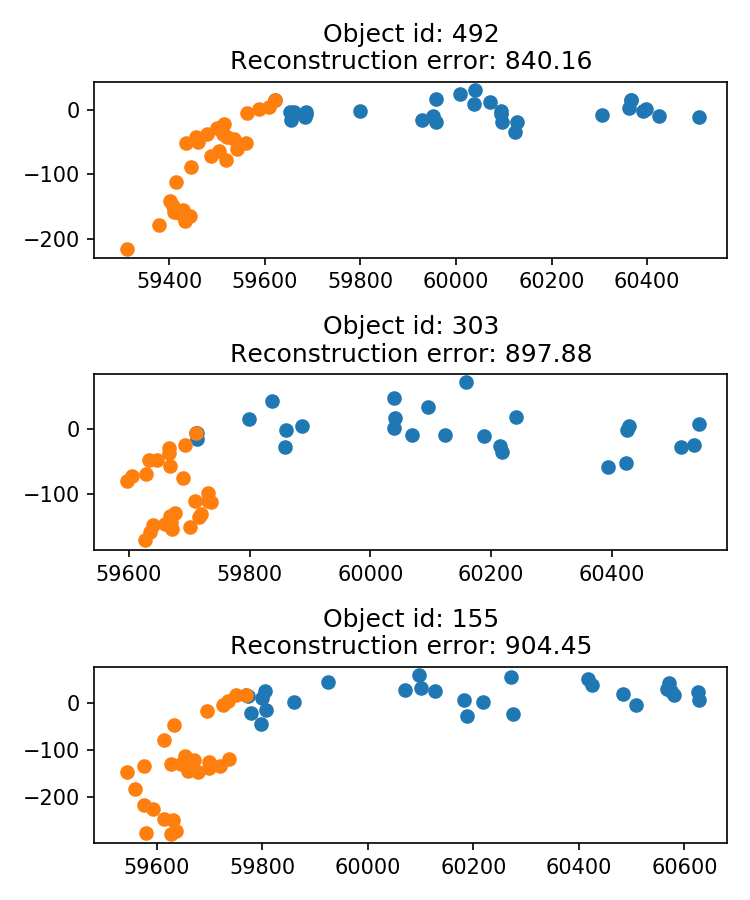

In [23]:
# plot light curves
n_lightCurves = 3

# # create random indexes
# indexes = np.random.randint(test_size, size= n_lightCurves)

# minimum error
indexes = loss_values_sorted[: n_lightCurves]

# # max error
# indexes = loss_values_sorted[:n_lightCurves:-1]

# create plot
fig, ax = plt.subplots(n_lightCurves, 1, figsize = (5,n_lightCurves * 2), tight_layout = True)


# plot light curves
for i in range(n_lightCurves):
    
    index = indexes[i]
    
    # add original
    ax[i].scatter(originalLightCurves[indexes[i], 0, mask[indexes[i]].astype(bool)], originalLightCurves[indexes[i], 1, mask[indexes[i]].astype(bool)], label = "original")
 
    # reconstructed data
    ax[i].scatter(reconstructedLightCurves[indexes[i], 0, mask[indexes[i]].astype(bool)], reconstructedLightCurves[indexes[i], 1, mask[indexes[i]].astype(bool)], label = "reconstructed")
    
    # add title
    ax[i].set_title("Object id: " + str(indexes[i]) + "\nReconstruction error: " + str(round(loss_values[indexes[i]], 2) )  )

# Unfolding

In [24]:
# plot fold light curve
def fold(time, period):
    """
    returns phase = time/period - floor(time/period)
    """
    return np.mod(time, period)/period

<IPython.core.display.Javascript object>


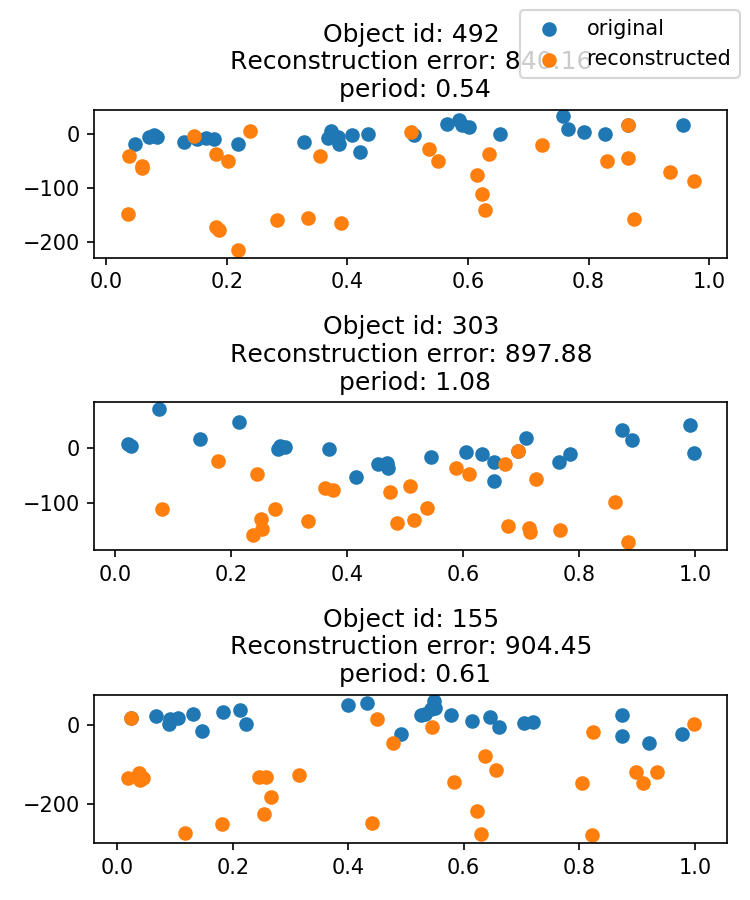

In [25]:
# library to get the period of a light curve
import P4J

# plot light curves
n_lightCurves = 3

# create random indexes
# indexes = np.random.randint(test_size, size= n_lightCurves)
# minimum error
indexes = loss_values_sorted[: n_lightCurves]

# max error
# indexes = loss_values_sorted[:n_lightCurves:-1]
# print(indexes)

# create plot
fig, ax = plt.subplots(n_lightCurves, 1, figsize = (5,n_lightCurves * 2), tight_layout = True)


# plot light curves
for i in range(n_lightCurves):
    
    index = indexes[i]
    
# #     # add original
#     ax[i].scatter(originalLightCurves[indexes[i], 0, mask[indexes[i]].astype(bool)], originalLightCurves[indexes[i], 1, mask[indexes[i]].astype(bool)], label = "original")
#     ax[i].scatter(reconstructedLightCurves[indexes[i], 0, mask[indexes[i]].astype(bool)], reconstructedLightCurves[indexes[i], 1, mask[indexes[i]].astype(bool)], label = "reconstructed")
#     ax[i].set_title("Object id: " + str(indexes[i]) + "\nReconstruction error: " + str(round(loss_values[indexes[i]], 2) )  )



    # get period of light curve
    my_per = P4J.periodogram(method='MHAOV') 
    
    # mjd, mag, err = lc_data[6].T
    mjd = originalLightCurves[index, 0, originalLightCurves[index, 3, :].astype(bool)]
    mag = originalLightCurves[index, 1, originalLightCurves[index, 3, :].astype(bool)]
    err = originalLightCurves[index, 2, originalLightCurves[index, 3, :].astype(bool)]
    
#     print(mag.shape)
    
    my_per.set_data(mjd, mag, err,h_KDE_P=0.2)
    my_per.frequency_grid_evaluation(fmin=0.0, fmax=4.0, fresolution=1e-4)
    my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=10)
    freq, per = my_per.get_periodogram()
    fbest, pbest  = my_per.get_best_frequencies()

    # period
    period = 1/fbest[0]

#     fig_, ax_ = plt.subplots(figsize=(9, 4), tight_layout=True)
    phi = fold(mjd, period)
    
    phi_ = fold(reconstructedLightCurves[indexes[i], 0, mask[indexes[i]].astype(bool)], period)
    
#     print(phi.shape)
#     ax_.errorbar(np.hstack((phi, phi+1)), 
#                 np.hstack((mag, mag)), 
#                 np.hstack((err, err)), fmt='o')
    
    # add original
    ax[i].scatter(phi, originalLightCurves[indexes[i], 1, mask[indexes[i]].astype(bool)], label = "original")
    ax[i].scatter(phi_, reconstructedLightCurves[indexes[i], 1, mask[indexes[i]].astype(bool)], label = "reconstructed")
#     ax[i].scatter(phi, reconstructedLightCurves[indexes[i], 1, mask[indexes[i]].astype(bool)], label = "reconstructed")
    ax[i].set_title("Object id: " + str(indexes[i]) + "\nReconstruction error: " + str(round(loss_values[indexes[i]], 2) ) + "\n period: " + str(round(period, 2))  )
    
    if i == 0:
        
        fig.legend()
        